In [29]:
import numpy as np
from monai.utils import set_determinism
from monai.inferers import sliding_window_inference
from monai.data import DataLoader,Dataset,decollate_batch
from monai.transforms import (
    AsDiscreted,
    EnsureChannelFirstd,
    Compose,
    LoadImaged,
    SaveImaged,
    EnsureTyped,
    Invertd,
    LoadImage,
)
from monai.networks.nets import UNet,UNETR,SwinUNETR
import os
import glob
import torch
from monai.networks.layers import Norm
from monai.handlers.utils import from_engine
from torch.nn.functional import softmax
import matplotlib.pyplot as plt

set_determinism(seed=0)

In [23]:
#dataset path - INSERT YOUR OWN PATH
ds_path = r"C:\Users\aless\OneDrive\Desktop\monai\monai_segmentation_ap\monai\prova_mri_segment\isbi_uint8"

#TODO delete
images = sorted(glob.glob(os.path.join(ds_path, "imagesTr","*.nii.gz")))
data_dict = [{"image":image_name} for image_name in images]
files = data_dict[-4:]

In [24]:
img_transforms = Compose(
    [
        LoadImaged(keys="image"),
        EnsureChannelFirstd(keys="image"),
        EnsureTyped(keys="image"),
    ]
)

ds = Dataset(data = files, transform=img_transforms)
loader = DataLoader(ds, batch_size=1)

post_transforms = Compose(
    [
        Invertd(
            keys="prediction",
            transform= img_transforms,
            orig_keys="image",
            meta_keys="prediction_meta_key",
            orig_meta_keys="image_meta_dict",
            meta_key_postfix="meta_dict",
            nearest_interp=False,
            to_tensor=True,
        ),
        AsDiscreted(keys="prediction",argmax=True, to_onehot=2),
        #TODO change the path of the output dir
        SaveImaged(keys="prediction",meta_keys="prediction_meta_key",output_dir="./output",output_postfix="pred",resample=False, separate_folder=False),
    ]
)

In [25]:
#MODELS
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
swin_unetr = SwinUNETR(
    in_channels=1,
    out_channels=2,
    img_size= (128,128,128),
    drop_rate=0.4,
).to(device)

unetr = UNETR(
    in_channels=1,
    out_channels=2,
    img_size=(128, 128, 128),
    feature_size=16,
    hidden_size=768,
    mlp_dim=3072,
    num_heads=12,
    norm_name="instance",
    pos_embed="perceptron",
    res_block=True,
    dropout_rate=0.4,
).to(device)

unet = UNet(    
    spatial_dims=3,
    in_channels=1,
    out_channels=2,
    channels=(16, 32, 64, 128, 256),
    strides=(2, 2, 2, 2),
    num_res_units=2,
    norm=Norm.BATCH,
).to(device)

In [26]:
swin_unetr.load_state_dict(torch.load("models_trained/swin_unetr.pth"))
swin_unetr.eval()
unetr.load_state_dict(torch.load("models_trained/unetr.pth"))
unetr.eval()
unet.load_state_dict(torch.load("models_trained/unet.pth"))
unet.eval()

weights = torch.Tensor([0.6480,0.6109,0.6307])
weights = softmax(weights,dim=0).to("cpu")

2024-10-10 11:06:16,219 INFO image_writer.py:197 - writing: output\training05_01_flair_pp_pred.nii.gz


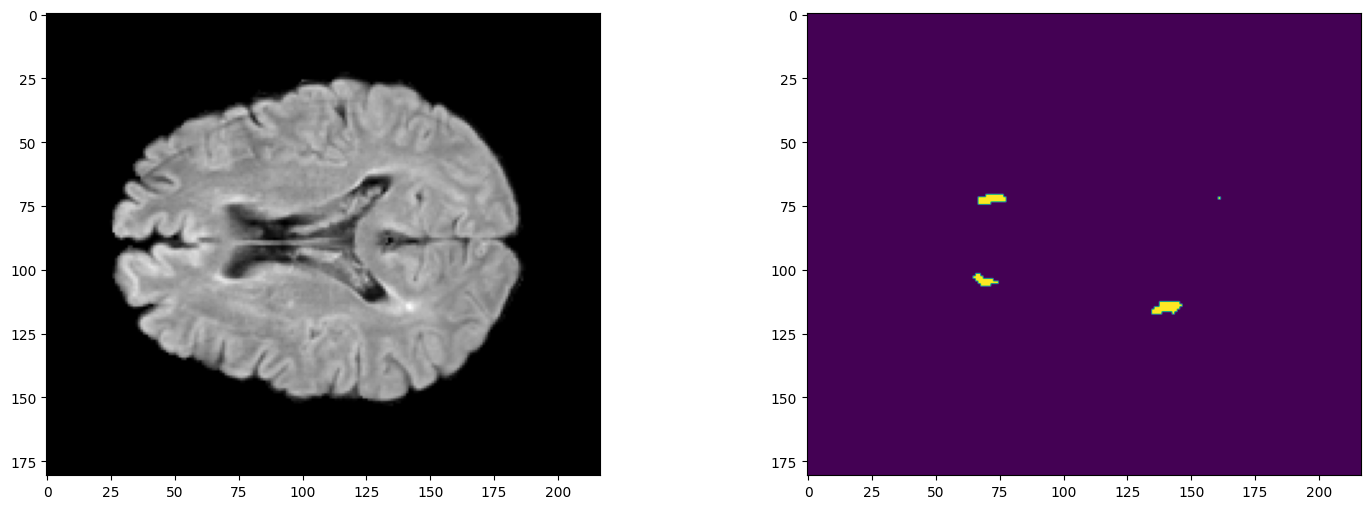

2024-10-10 11:06:25,063 INFO image_writer.py:197 - writing: output\training05_02_flair_pp_pred.nii.gz


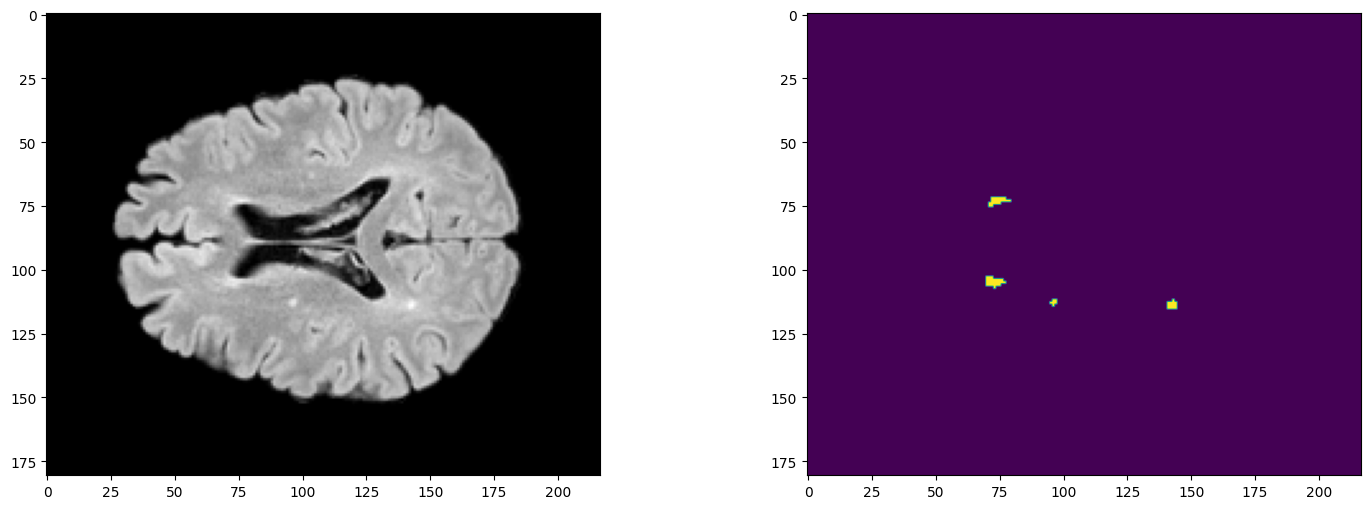

2024-10-10 11:06:33,852 INFO image_writer.py:197 - writing: output\training05_03_flair_pp_pred.nii.gz


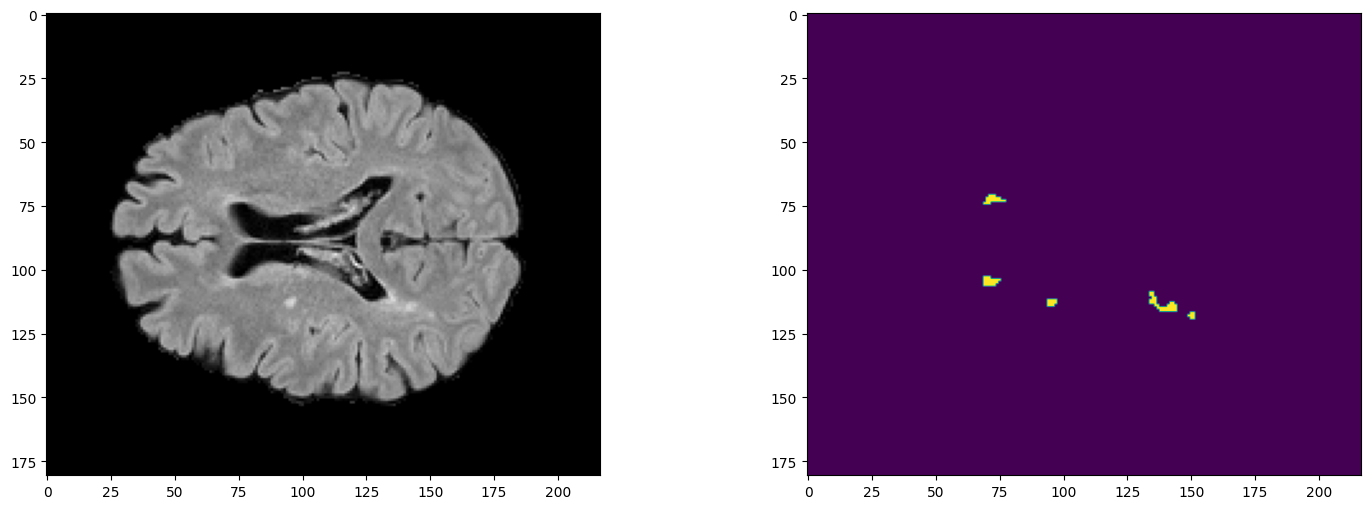

2024-10-10 11:06:42,421 INFO image_writer.py:197 - writing: output\training05_04_flair_pp_pred.nii.gz


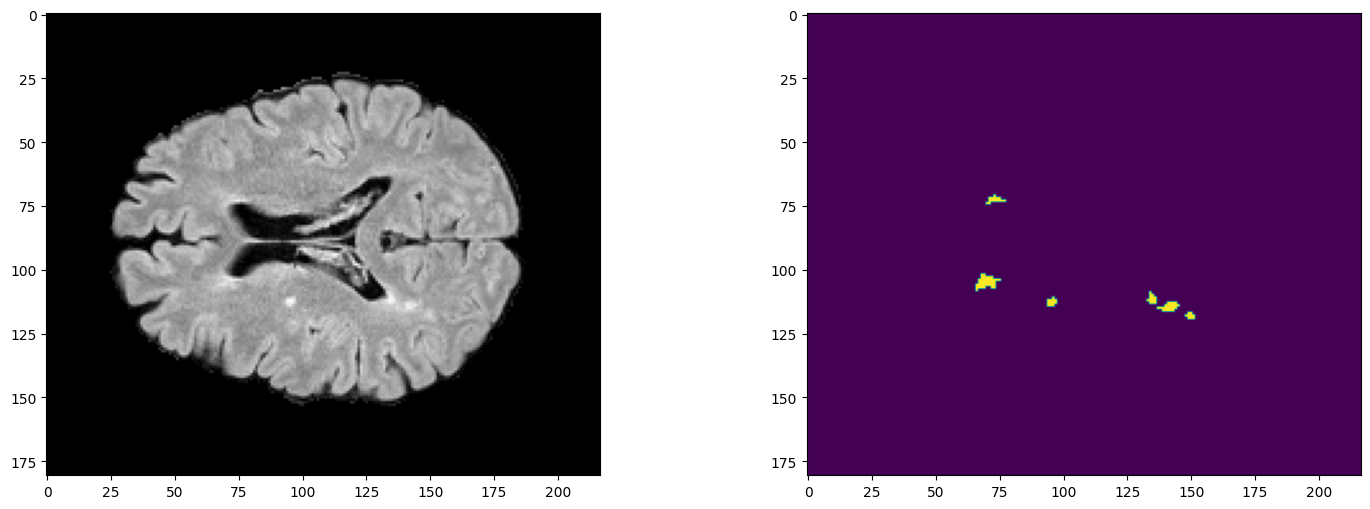

In [30]:
img_loader = LoadImage()

with torch.no_grad():
    for test_data in loader:
        test_input = test_data["image"].to(device)
        roi_size = (128,128,128)
        sw_bacth_size = 4
        output_swin = sliding_window_inference(test_input,roi_size,sw_bacth_size,swin_unetr)
        output_unet = sliding_window_inference(test_input,roi_size,sw_bacth_size,unet)
        output_unetr = sliding_window_inference(test_input,roi_size,sw_bacth_size,unetr)
        weighted_stack = (output_swin * weights[0] + output_unetr * weights[1] + output_unet * weights[2])
        final_mask = weighted_stack / torch.sum(weights)
        
        test_data["prediction"] = final_mask
        test_data = [post_transforms(i) for i in decollate_batch(test_data)]
        test_output = from_engine("prediction")(test_data)
        original_image = img_loader(test_output[0].meta["filename_or_obj"])
        
        #image plot
        plt.figure("check",(18,6))
        plt.subplot(1,2,1)
        plt.imshow(original_image[:,:,90],cmap="gray")
        plt.subplot(1,2,2)
        plt.imshow(test_output[0].detach().cpu()[1,:,:,90])
        plt.show()